In [1]:
# necessary imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import PIL
import pathlib

import tensorflow as tf
from tensorflow import keras

In [2]:
# setting up paths for train/valid/test
train_dir = pathlib.Path('/Users/elliotttrott/Desktop/CTscns2/train')
val_dir = pathlib.Path('/Users/elliotttrott/Desktop/CTscns2/valid')
test_dir = pathlib.Path('/Users/elliotttrott/Desktop/CTscns2/test')

# show the quantity of images in the set a different way
train_image_count = len(list(train_dir.glob('*/*.png')))
train_image_count

601

In [3]:
# setting up batch/image sizes 
batch_size = 32
image_width = 224
image_height = 224

train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=123,
    #validation_split=0.5,
    #subset='training',
    image_size=(image_height, image_width),
    batch_size=batch_size
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size
)

test_ds = keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size
)

Found 613 files belonging to 2 classes.
Found 72 files belonging to 2 classes.
Found 315 files belonging to 2 classes.


2022-07-13 11:30:12.434087: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Have already seen the brekadown of data by categry

In [4]:
## naming classes

class_names = ["Cancerous",
"normal"]

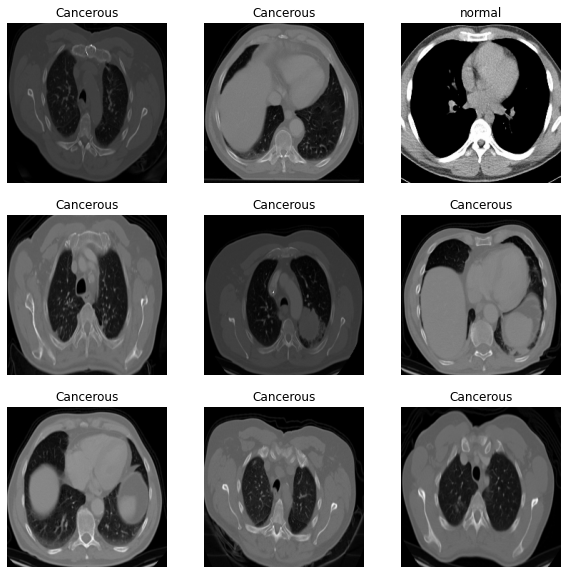

In [5]:
# plotting some examples again
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [6]:
# importing a pretrained model MobileNet, using imagenet weights (these will be changed later)
base_model = keras.applications.MobileNetV3Small(input_shape=(image_width, image_height, 3),
                                            classes=400,
                                            include_top=False,
                                            weights='imagenet')

6709248/6698480 [==============================] - 1s 0us/step


In [7]:
# Freeze certain layers that we want untrainable
base_model.trainable = False
base_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [8]:
# some data augmentation here as currently we are not working with a lage data set

data_augmentation = keras.models.Sequential([
  keras.layers.RandomFlip('horizontal'),
  keras.layers.RandomRotation(0.2)
])

In [9]:
num_classes = len(class_names)

inputs = keras.Input(shape=(image_width, image_height, 3))
#x = data_augmentation(inputs)
x = keras.applications.mobilenet_v3.preprocess_input(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)


outputs = keras.layers.Dense(num_classes, activation='softmax')(x) # last layer softmax 
model = keras.Model(inputs, outputs)

In [10]:
# compiling model metrics = accuracy
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 1, 1, 1024)       1529968   
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 2)                 2050      
                                                                 
Total params: 1,532,018
Trainable params: 2,050
Non-trainable

Model summary is featured above -- 1,532,018 total parameters

In [11]:
# performing 20 epochs at first
initial_epochs = 20

early_stop = keras.callbacks.EarlyStopping(patience=1, restore_best_weights=True)

# code for training the model over the training data using the validation also
history = model.fit(train_ds, 
          validation_data=val_ds,
          epochs=initial_epochs,
          callbacks=[early_stop])

Epoch 1/20
20/20 [==============================] - 8s 280ms/step - loss: 0.3381 - accuracy: 0.8418 - val_loss: 0.0950 - val_accuracy: 0.9722
Epoch 2/20
20/20 [==============================] - 5s 246ms/step - loss: 0.1286 - accuracy: 0.9511 - val_loss: 0.0551 - val_accuracy: 0.9722
Epoch 3/20
20/20 [==============================] - 5s 245ms/step - loss: 0.0869 - accuracy: 0.9690 - val_loss: 0.0458 - val_accuracy: 0.9722
Epoch 4/20
20/20 [==============================] - 5s 245ms/step - loss: 0.0751 - accuracy: 0.9755 - val_loss: 0.0415 - val_accuracy: 0.9861
Epoch 5/20
20/20 [==============================] - 5s 247ms/step - loss: 0.0600 - accuracy: 0.9788 - val_loss: 0.0371 - val_accuracy: 0.9861
Epoch 6/20
20/20 [==============================] - 5s 247ms/step - loss: 0.0517 - accuracy: 0.9837 - val_loss: 0.0358 - val_accuracy: 0.9861
Epoch 7/20
20/20 [==============================] - 5s 249ms/step - loss: 0.0475 - accuracy: 0.9837 - val_loss: 0.0334 - val_accuracy: 0.9861
Epoch 

looks to be very accurate over the training data

In [12]:
initial_epochs = len(history.history['accuracy'])

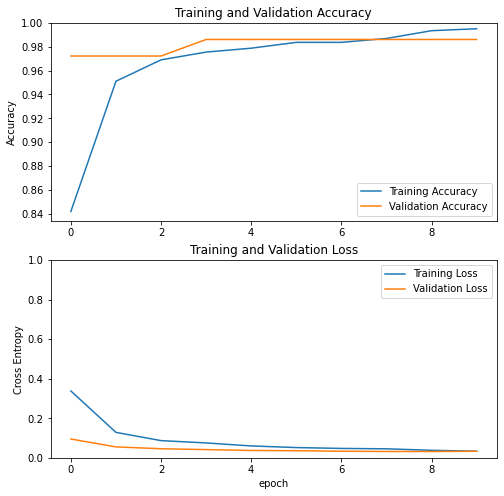

In [13]:
# plotting the metric accuracy over epochs 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# doing the same for the loss function
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

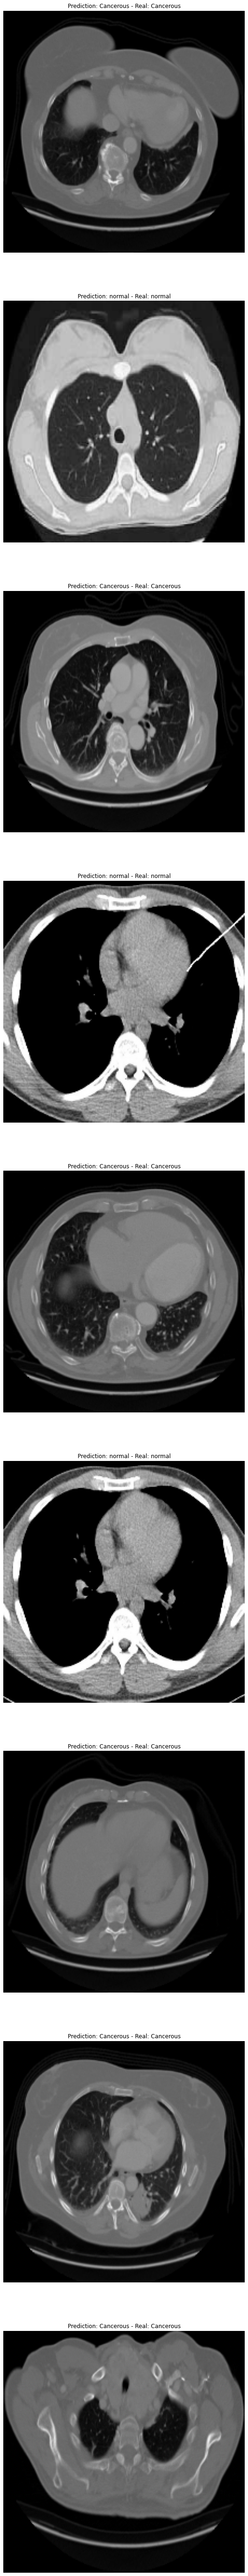

In [14]:
# make a prediction and compare to the real on the same plot - image taken from the test data set
plt.figure(figsize=(10, 100))
for images, labels in test_ds.take(1):
    prediction = model.predict(images,batch_size=32)
    for i in range(9):
        ax = plt.subplot(9, 1, i+1)
        pred = np.argmax(prediction[i])
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f'Prediction: {class_names[pred]} - Real: {class_names[labels[i]]}')
        plt.axis('off')

Prediction is correct from these images. Test larger batches to judge accuracy?

In [15]:
test_ds_unbatch = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=None,
    shuffle=False,
    image_size=(image_height, image_width),
    batch_size=image_height,
)
images = list(test_ds_unbatch.map(lambda x, y: x))
labels = list(test_ds_unbatch.map(lambda x, y: y))

Found 315 files belonging to 2 classes.


In [16]:
# make predictions over the test data
y_test = np.concatenate([y for x, y in test_ds_unbatch], axis=0)
prediction = model.predict(test_ds_unbatch)
pred = np.argmax(prediction,axis=1)
print(pred)    
from sklearn.metrics import accuracy_score

accuracy_score(pred,y_test) # show the accuracy

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]


0.9936507936507937

Accuracy of 99% over the test data, this model appears to be highly accurate at determining whether an individial is displaying signs of solid tumours.

In [17]:
# plot a confusion matrix 

# imports
from sklearn import metrics


confusion_matrix = metrics.confusion_matrix(pred, y_test)
confusion_matrix = confusion_matrix.astype(int)

In [20]:
# more imports 
import plotly.figure_factory as ff
# need to pip install in terminal along with cufflinks

# defining the confusion plot
def plot_confusion_matrix(z,x,y):
    x = x
    y = x[::-1].copy()
    z = z[::-1]
    # change each element of z to string - annotate
    z_text = [[str(y) for y in x] for x in z[::-1]]

    # figure set up
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='<i><b>Matriz de Confusão</b></i>',
                      #xaxis = dict(title='x'),
                      #yaxis = dict(title='x')
                     )

    # x axis title
    fig.add_annotation(dict(font=dict(color="black",size=14),
                            x=0.5,
                            y=-0.15,
                            showarrow=False,
                            text="Valor Previsto",
                            xref="paper",
                            yref="paper"))

    # y axis title
    fig.add_annotation(dict(font=dict(color="black",size=14),
                            x=-0.35,
                            y=0.5,
                            showarrow=False,
                            text="Valor Real",
                            textangle=-90,
                            xref="paper",
                            yref="paper"))

    # adjust margins 
    fig.update_layout(margin=dict(t=50, l=200))
    fig.update_yaxes(type='category')
    # add colour
    fig['data'][0]['showscale'] = True
    fig.show()

In [21]:
import plotly.express as px

z = confusion_matrix
fig = px.imshow(z)
fig.show()
# plot the confusion matrix

In [22]:
z = confusion_matrix[:10,:10]
fig = px.imshow(z)
fig.show()

In [23]:
base_model.trainable = True

# Fine-tuning
fine_tune_at = 100

# freezing some layerss
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [24]:
# setting the base LR
base_learning_rate = 0.0001
# compiling model again
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
# to avoid overfitting use a lower LR

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 1, 1, 1024)       1529968   
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 2)                 2050      
                                                                 
Total params: 1,532,018
Trainable params: 1,406,434
Non-train

In [25]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

early_stop = keras.callbacks.EarlyStopping(patience=1, restore_best_weights=True)

# train the model again
history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,
                         callbacks=[early_stop])

Epoch 10/20
20/20 [==============================] - 13s 446ms/step - loss: 0.0297 - accuracy: 0.9935 - val_loss: 0.0296 - val_accuracy: 0.9861
Epoch 11/20
20/20 [==============================] - 10s 472ms/step - loss: 0.0242 - accuracy: 0.9951 - val_loss: 0.0358 - val_accuracy: 0.9861


Accuracy has been boosted by, fine tuning appears to have worked

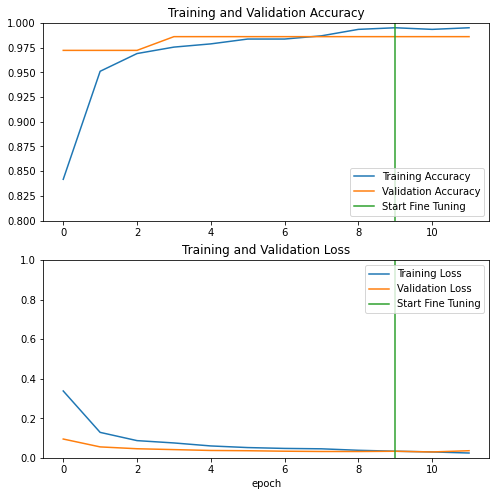

In [26]:
# plotting new graphs for accuracy and loss with fine tuninng included
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [27]:
# evaluate over the test data for metric of accuracy
model.evaluate(test_ds)

10/10 [==============================] - 2s 224ms/step - loss: 0.0265 - accuracy: 0.9968


[0.026489997282624245, 0.9968253970146179]

Accuracy is at 99.7% for this model:)